# Yet another Movie Recommender from scratch
> Building and training Item-popularity and MLP model on movielens dataset in pure pytorch

- toc: true
- badges: true
- comments: true
- categories: [PyTorch, Movie, MLP]
- author: "<a href='https://github.com/HarshdeepGupta/recommender_pytorch'>Harshdeep Gupta</a>"
- image:

## Setup

In [8]:
import math
import torch
import heapq
import pickle
import argparse
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
from time import time
import scipy.sparse as sp
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [9]:
np.random.seed(7)
torch.manual_seed(0)

_model = None
_testRatings = None
_testNegatives = None
_topk = None

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Data Loading

In [4]:
!wget https://github.com/HarshdeepGupta/recommender_pytorch/raw/master/Data/movielens.train.rating
!wget https://github.com/HarshdeepGupta/recommender_pytorch/raw/master/Data/movielens.test.rating
!wget https://github.com/HarshdeepGupta/recommender_pytorch/raw/master/Data/u.data

--2021-07-12 05:23:32--  https://github.com/HarshdeepGupta/recommender_pytorch/raw/master/Data/movielens.train.rating
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HarshdeepGupta/recommender_pytorch/master/Data/movielens.train.rating [following]
--2021-07-12 05:23:32--  https://raw.githubusercontent.com/HarshdeepGupta/recommender_pytorch/master/Data/movielens.train.rating
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1960426 (1.9M) [text/plain]
Saving to: ‘movielens.train.rating’

movielens.train.rat 100%[===================>]   1.87M  --.-KB/s    in 0.06s   

2021-07-12 05:23:33 (30.1 MB/s)

## Eval Methods

In [10]:
def evaluate_model(model, full_dataset: MovieLensDataset, topK: int):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    global _model
    global _testRatings
    global _testNegatives
    global _topk
    _model = model
    _testRatings = full_dataset.testRatings
    _testNegatives = full_dataset.testNegatives
    _topk = topK

    hits, ndcgs = [], []
    for idx in range(len(_testRatings)):
        (hr, ndcg) = eval_one_rating(idx, full_dataset)
        hits.append(hr)
        ndcgs.append(ndcg)
    return (hits, ndcgs)


def eval_one_rating(idx, full_dataset: MovieLensDataset):
    rating = _testRatings[idx]
    items = _testNegatives[idx]
    u = rating[0]

    gtItem = rating[1]
    items.append(gtItem)
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), u, dtype='int32')

    feed_dict = {
        'user_id': users,
        'item_id': np.array(items),
    }
    predictions = _model.predict(feed_dict)
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]

    # Evaluate top rank list
    ranklist = heapq.nlargest(_topk, map_item_score, key=map_item_score.get)
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    return (hr, ndcg)

## Eval Metrics

In [11]:
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0


def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

## Pytorch Dataset

In [12]:
class MovieLensDataset(Dataset):
    'Characterizes the dataset for PyTorch, and feeds the (user,item) pairs for training'

    def __init__(self, file_name, num_negatives_train=5, num_negatives_test=100):
        'Load the datasets from disk, and store them in appropriate structures'

        self.trainMatrix = self.load_rating_file_as_matrix(
            file_name + ".train.rating")
        self.num_users, self.num_items = self.trainMatrix.shape
        # make training set with negative sampling
        self.user_input, self.item_input, self.ratings = self.get_train_instances(
            self.trainMatrix, num_negatives_train)
        # make testing set with negative sampling
        self.testRatings = self.load_rating_file_as_list(
            file_name + ".test.rating")
        self.testNegatives = self.create_negative_file(
            num_samples=num_negatives_test)
        assert len(self.testRatings) == len(self.testNegatives)

    def __len__(self):
        'Denotes the total number of rating in test set'
        return len(self.user_input)

    def __getitem__(self, index):
        'Generates one sample of data'

        # get the train data
        user_id = self.user_input[index]
        item_id = self.item_input[index]
        rating = self.ratings[index]

        return {'user_id': user_id,
                'item_id': item_id,
                'rating': rating}

    def get_train_instances(self, train, num_negatives):
        user_input, item_input, ratings = [], [], []
        num_users, num_items = train.shape
        for (u, i) in train.keys():
            # positive instance
            user_input.append(u)
            item_input.append(i)
            ratings.append(1)
            # negative instances
            for _ in range(num_negatives):
                j = np.random.randint(1, num_items)
                # while train.has_key((u, j)):
                while (u, j) in train:
                    j = np.random.randint(1, num_items)
                user_input.append(u)
                item_input.append(j)
                ratings.append(0)
        return user_input, item_input, ratings

    def load_rating_file_as_list(self, filename):
        ratingList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList

    def create_negative_file(self, num_samples=100):
        negativeList = []
        for user_item_pair in self.testRatings:
            user = user_item_pair[0]
            item = user_item_pair[1]
            negatives = []
            for t in range(num_samples):
                j = np.random.randint(1, self.num_items)
                while (user, j) in self.trainMatrix or j == item:
                    j = np.random.randint(1, self.num_items)
                negatives.append(j)
            negativeList.append(negatives)
        return negativeList

    def load_rating_file_as_matrix(self, filename):
        '''
        Read .rating file and Return dok matrix.
        The first line of .rating file is: num_users\t num_items
        '''
        # Get number of users and items
        num_users, num_items = 0, 0
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
        # Construct matrix
        mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mat[user, item] = 1.0
                line = f.readline()
        return mat

## Utils

In [13]:
def train_one_epoch(model, data_loader, loss_fn, optimizer, epoch_no, device, verbose = 1):
    'trains the model for one epoch and returns the loss'
    print("Epoch = {}".format(epoch_no))
    # Training
    # get user, item and rating data
    t1 = time()
    epoch_loss = []
    # put the model in train mode before training
    model.train()
    # transfer the data to GPU
    for feed_dict in data_loader:
        for key in feed_dict:
            if type(feed_dict[key]) != type(None):
                feed_dict[key] = feed_dict[key].to(dtype = torch.long, device = device)
        # get the predictions
        prediction = model(feed_dict)
        # print(prediction.shape)
        # get the actual targets
        rating = feed_dict['rating']
        
      
        # convert to float and change dim from [batch_size] to [batch_size,1]
        rating = rating.float().view(prediction.size())  
        loss = loss_fn(prediction, rating)
        # clear the gradients
        optimizer.zero_grad()
        # backpropagate
        loss.backward()
        # update weights
        optimizer.step()
        # accumulate the loss for monitoring
        epoch_loss.append(loss.item())
    epoch_loss = np.mean(epoch_loss)
    if verbose:
        print("Epoch completed {:.1f} s".format(time() - t1))
        print("Train Loss: {}".format(epoch_loss))
    return epoch_loss
        

def test(model, full_dataset : MovieLensDataset, topK):
    'Test the HR and NDCG for the model @topK'
    # put the model in eval mode before testing
    if hasattr(model,'eval'):
        # print("Putting the model in eval mode")
        model.eval()
    t1 = time()
    (hits, ndcgs) = evaluate_model(model, full_dataset, topK)
    hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
    print('Eval: HR = %.4f, NDCG = %.4f [%.1f s]' % (hr, ndcg, time()-t1))
    return hr, ndcg
    

def plot_statistics(hr_list, ndcg_list, loss_list, model_alias, path):
    'plots and saves the figures to a local directory'
    plt.figure()
    hr = np.vstack([np.arange(len(hr_list)),np.array(hr_list)]).T
    ndcg = np.vstack([np.arange(len(ndcg_list)),np.array(ndcg_list)]).T
    loss = np.vstack([np.arange(len(loss_list)),np.array(loss_list)]).T
    plt.plot(hr[:,0], hr[:,1],linestyle='-', marker='o', label = "HR")
    plt.plot(ndcg[:,0], ndcg[:,1],linestyle='-', marker='v', label = "NDCG")
    plt.plot(loss[:,0], loss[:,1],linestyle='-', marker='s', label = "Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.savefig(path+model_alias+".jpg")
    return


def get_items_interacted(user_id, interaction_df):
    # returns a set of items the user has interacted with
    userid_mask = interaction_df['userid'] == user_id
    interacted_items = interaction_df.loc[userid_mask].courseid
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])


def save_to_csv(df,path, header = False, index = False, sep = '\t', verbose = False):
    if verbose:
        print("Saving df to path: {}".format(path))
        print("Columns in df are: {}".format(df.columns.tolist()))

    df.to_csv(path, header = header, index = index, sep = sep)

## Item Popularity Model

In [18]:
def parse_args():
    parser = argparse.ArgumentParser(description="Run ItemPop")
    parser.add_argument('--path', nargs='?', default='/content/',
                        help='Input data path.')
    parser.add_argument('--dataset', nargs='?', default='movielens',
                        help='Choose a dataset.')
    parser.add_argument('--num_neg_test', type=int, default=100,
                        help='Number of negative instances to pair with a positive instance while testing')
    
    return parser.parse_args(args={})

In [19]:
class ItemPop():
    def __init__(self, train_interaction_matrix: sp.dok_matrix):
        """
        Simple popularity based recommender system
        """
        self.__alias__ = "Item Popularity without metadata"
        # Sum the occurences of each item to get is popularity, convert to array and 
        # lose the extra dimension
        self.item_ratings = np.array(train_interaction_matrix.sum(axis=0, dtype=int)).flatten()

    def forward(self):
        pass

    def predict(self, feeddict) -> np.array:
        # returns the prediction score for each (user,item) pair in the input
        items = feeddict['item_id']
        output_scores = [self.item_ratings[itemid] for itemid in items]
        return np.array(output_scores)

    def get_alias(self):
        return self.__alias__

In [20]:
args = parse_args()
path = args.path
dataset = args.dataset
num_negatives_test = args.num_neg_test
print("Model arguments: %s " %(args))

topK = 10

# Load data

t1 = time()
full_dataset = MovieLensDataset(path + dataset, num_negatives_test=num_negatives_test)
train, testRatings, testNegatives = full_dataset.trainMatrix, full_dataset.testRatings, full_dataset.testNegatives
num_users, num_items = train.shape
print("Load data done [%.1f s]. #user=%d, #item=%d, #train=%d, #test=%d"
      % (time()-t1, num_users, num_items, train.nnz, len(testRatings)))

model = ItemPop(train)
test(model, full_dataset, topK)

Model arguments: Namespace(dataset='movielens', num_neg_test=100, path='/content/') 
Load data done [4.3 s]. #user=944, #item=1683, #train=99057, #test=943
Eval: HR = 0.4062, NDCG = 0.2199 [0.1 s]


(0.4061505832449629, 0.21988638109018463)

## MLP Model

In [21]:
def parse_args():
    parser = argparse.ArgumentParser(description="Run MLP.")
    parser.add_argument('--path', nargs='?', default='/content/',
                        help='Input data path.')
    parser.add_argument('--dataset', nargs='?', default='movielens',
                        help='Choose a dataset.')
    parser.add_argument('--epochs', type=int, default=30,
                        help='Number of epochs.')
    parser.add_argument('--batch_size', type=int, default=256,
                        help='Batch size.')
    parser.add_argument('--layers', nargs='?', default='[16,32,16,8]',
                        help="Size of each layer. Note that the first layer is the concatenation of user and item embeddings. So layers[0]/2 is the embedding size.")
    parser.add_argument('--weight_decay', type=float, default=0.00001,
                        help="Regularization for each layer")
    parser.add_argument('--num_neg_train', type=int, default=4,
                        help='Number of negative instances to pair with a positive instance while training')
    parser.add_argument('--num_neg_test', type=int, default=100,
                        help='Number of negative instances to pair with a positive instance while testing')
    parser.add_argument('--lr', type=float, default=0.001,
                        help='Learning rate.')
    parser.add_argument('--dropout', type=float, default=0,
                        help='Add dropout layer after each dense layer, with p = dropout_prob')
    parser.add_argument('--learner', nargs='?', default='adam',
                        help='Specify an optimizer: adagrad, adam, rmsprop, sgd')
    parser.add_argument('--verbose', type=int, default=1,
                        help='Show performance per X iterations')
    parser.add_argument('--out', type=int, default=1,
                        help='Whether to save the trained model.')
    return parser.parse_args(args={})

In [45]:
class MLP(nn.Module):

    def __init__(self, n_users, n_items, layers=[16, 8], dropout=False):
        """
        Simple Feedforward network with Embeddings for users and items
        """
        super().__init__()
        assert (layers[0] % 2 == 0), "layers[0] must be an even number"
        self.__alias__ = "MLP {}".format(layers)
        self.__dropout__ = dropout

        # user and item embedding layers
        embedding_dim = int(layers[0]/2)
        self.user_embedding = torch.nn.Embedding(n_users, embedding_dim)
        self.item_embedding = torch.nn.Embedding(n_items, embedding_dim)

        # list of weight matrices
        self.fc_layers = torch.nn.ModuleList()
        # hidden dense layers
        for _, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
        # final prediction layer
        self.output_layer = torch.nn.Linear(layers[-1], 1)

    def forward(self, feed_dict):
        users = feed_dict['user_id']
        items = feed_dict['item_id']
        user_embedding = self.user_embedding(users)
        item_embedding = self.item_embedding(items)
        # concatenate user and item embeddings to form input
        x = torch.cat([user_embedding, item_embedding], 1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            x = self.fc_layers[idx](x)
            x = F.relu(x)
            x = F.dropout(x,  p=self.__dropout__, training=self.training)
        logit = self.output_layer(x)
        rating = torch.sigmoid(logit)
        return rating

    def predict(self, feed_dict):
        # return the score, inputs and outputs are numpy arrays
        for key in feed_dict:
            if type(feed_dict[key]) != type(None):
                feed_dict[key] = torch.from_numpy(
                    feed_dict[key]).to(dtype=torch.long, device=device)
        output_scores = self.forward(feed_dict)
        return output_scores.cpu().detach().numpy()

    def get_alias(self):
        return self.__alias__

Device available: cpu
MLP arguments: Namespace(batch_size=256, dataset='movielens', dropout=0, epochs=30, layers='[16,32,16,8]', learner='adam', lr=0.001, num_neg_test=100, num_neg_train=4, out=1, path='/content/', verbose=1, weight_decay=1e-05) 
Load data done [3.8 s]. #user=944, #item=1683, #train=99057, #test=943
MLP(
  (user_embedding): Embedding(944, 8)
  (item_embedding): Embedding(1683, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
)
Eval: HR = 0.0848, NDCG = 0.0386 [0.6 s]
Epoch = 0
Epoch completed 5.8 s
Train Loss: 0.4429853802195507
Eval: HR = 0.3945, NDCG = 0.2187 [0.6 s]
Epoch = 1
Epoch completed 5.6 s
Train Loss: 0.3646208482657292
Eval: HR = 0.3818, NDCG = 0.2133 [0.6 s]
Epoch = 2
Epoch completed 5.6 s
Train Loss: 0.35764367812979747
Eval: HR

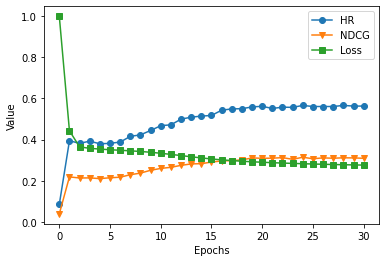

In [46]:
print("Device available: {}".format(device))

args = parse_args()
path = args.path
dataset = args.dataset
layers = eval(args.layers)
weight_decay = args.weight_decay
num_negatives_train = args.num_neg_train
num_negatives_test = args.num_neg_test
dropout = args.dropout
learner = args.learner
learning_rate = args.lr
batch_size = args.batch_size
epochs = args.epochs
verbose = args.verbose

topK = 10
print("MLP arguments: %s " % (args))
model_out_file = '%s_MLP_%s_%d.h5' %(args.dataset, args.layers, time())

# Load data

t1 = time()
full_dataset = MovieLensDataset(
    path + dataset, num_negatives_train=num_negatives_train, num_negatives_test=num_negatives_test)
train, testRatings, testNegatives = full_dataset.trainMatrix, full_dataset.testRatings, full_dataset.testNegatives
num_users, num_items = train.shape
print("Load data done [%.1f s]. #user=%d, #item=%d, #train=%d, #test=%d"
      % (time()-t1, num_users, num_items, train.nnz, len(testRatings)))

training_data_generator = DataLoader(
    full_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Build model
model = MLP(num_users, num_items, layers=layers, dropout=dropout)
# Transfer the model to GPU, if one is available
model.to(device)
if verbose:
    print(model)

loss_fn = torch.nn.BCELoss()
# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)

# Record performance
hr_list = []
ndcg_list = []
BCE_loss_list = []

# Check Init performance
hr, ndcg = test(model, full_dataset, topK)
hr_list.append(hr)
ndcg_list.append(ndcg)
BCE_loss_list.append(1)

# do the epochs now

for epoch in range(epochs):
    epoch_loss = train_one_epoch( model, training_data_generator, loss_fn, optimizer, epoch, device)

    if epoch % verbose == 0:
        hr, ndcg = test(model, full_dataset, topK)
        hr_list.append(hr)
        ndcg_list.append(ndcg)
        BCE_loss_list.append(epoch_loss)
        if hr > max(hr_list):
            if args.out > 0:
                model.save(model_out_file, overwrite=True)

print("hr for epochs: ", hr_list)
print("ndcg for epochs: ", ndcg_list)
print("loss for epochs: ", BCE_loss_list)
plot_statistics(hr_list, ndcg_list, BCE_loss_list, model.get_alias(), "/content")
with open("metrics", 'wb') as fp:
    pickle.dump(hr_list, fp)
    pickle.dump(ndcg_list, fp)

best_iter = np.argmax(np.array(hr_list))
best_hr = hr_list[best_iter]
best_ndcg = ndcg_list[best_iter]
print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %
      (best_iter, best_hr, best_ndcg))
if args.out > 0:
    print("The best MLP model is saved to %s" %(model_out_file))